In [1]:
import datamol as dm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import PairwiseKernel, Sum, WhiteKernel

from mood.dataset import dataset_iterator, load_data_from_tdc, MOOD_REGR_DATASETS, MOOD_CLSF_DATASETS
from mood.model_space import ModelSpaceTransformer
from mood.preprocessing import standardize_smiles
from mood.distance import compute_knn_distance
from mood.visualize import plot_distance_distributions
from mood.representations import representation_iterator, featurize
from mood.constants import DOWNSTREAM_APPS_DATA_DIR
from mood.utils import load_representation_for_downstream_application, save_figure_with_fsspec

In [2]:
def get_model_space_distances(model, train, queries):
    trans = ModelSpaceTransformer(model)

    model_space_train = trans(train)
    queries = [trans(q) for q in queries]

    distances = compute_knn_distance(
        model_space_train, 
        queries, 
        n_jobs=-1
    )
    return distances

In [3]:
BASE_SAVE_DIR = "gs://experiments-output/mood-v2/results/figures/"
OVERWRITE = True

today = datetime.now().strftime("%Y%m%d")
save_dir = dm.fs.join(BASE_SAVE_DIR, f"{today}_NB01")

Found local copy...
Loading...
Done!


Preprocess DILI:   0%|          | 0/475 [00:00<?, ?it/s]

MACCS:   0%|          | 0/475 [00:00<?, ?it/s]

ECFP6:   0%|          | 0/475 [00:00<?, ?it/s]

Desc2D:   0%|          | 0/475 [00:00<?, ?it/s]

WHIM:   0%|          | 0/475 [00:00<?, ?it/s]

Found local copy...
Loading...
Done!


Preprocess HIA:   0%|          | 0/578 [00:00<?, ?it/s]

MACCS:   0%|          | 0/578 [00:00<?, ?it/s]

ECFP6:   0%|          | 0/578 [00:00<?, ?it/s]

Desc2D:   0%|          | 0/578 [00:00<?, ?it/s]

WHIM:   0%|          | 0/578 [00:00<?, ?it/s]

Found local copy...
Loading...
Done!


Preprocess Pgp:   0%|          | 0/1218 [00:00<?, ?it/s]

MACCS:   0%|          | 0/1218 [00:00<?, ?it/s]

ECFP6:   0%|          | 0/1218 [00:00<?, ?it/s]

Desc2D:   0%|          | 0/1218 [00:00<?, ?it/s]

WHIM:   0%|          | 0/1218 [00:00<?, ?it/s]

Downloading...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50.2k/50.2k [00:00<00:00, 2.60MiB/s]
Loading...
Done!


Preprocess hERG:   0%|          | 0/655 [00:00<?, ?it/s]

MACCS:   0%|          | 0/655 [00:00<?, ?it/s]

ECFP6:   0%|          | 0/655 [00:00<?, ?it/s]

Desc2D:   0%|          | 0/655 [00:00<?, ?it/s]

/home/cas/Documents/repositories/mood_v2/notebooks/../mood/representations.py:144: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.nanmax(atomic_charges)


WHIM:   0%|          | 0/655 [00:00<?, ?it/s]

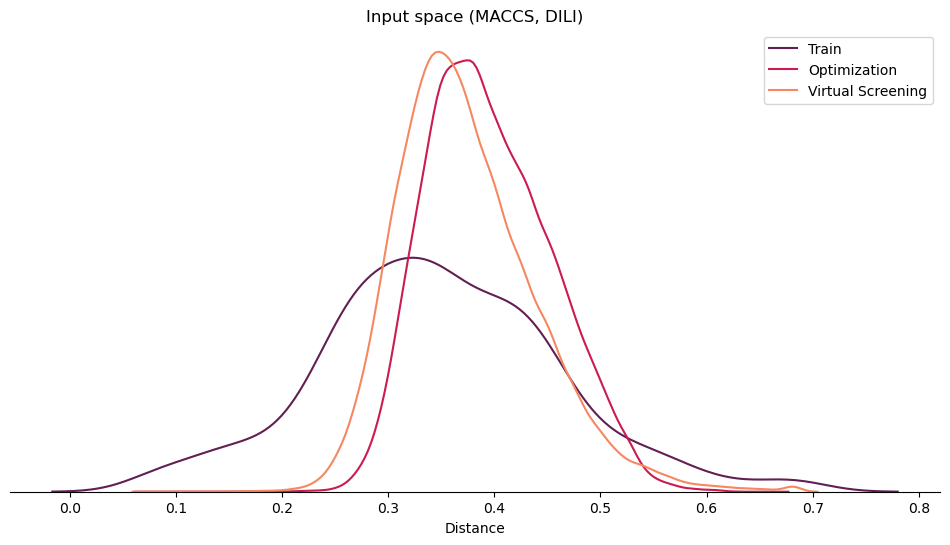

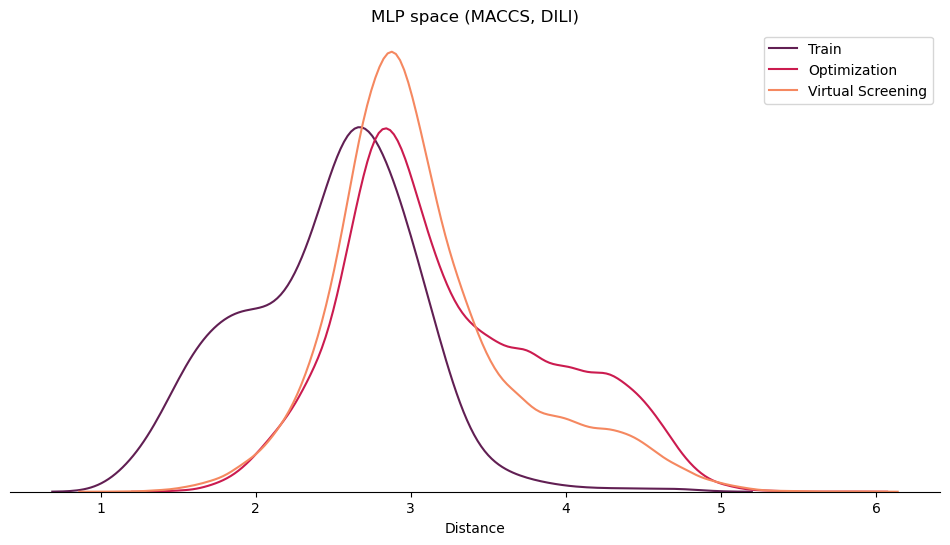

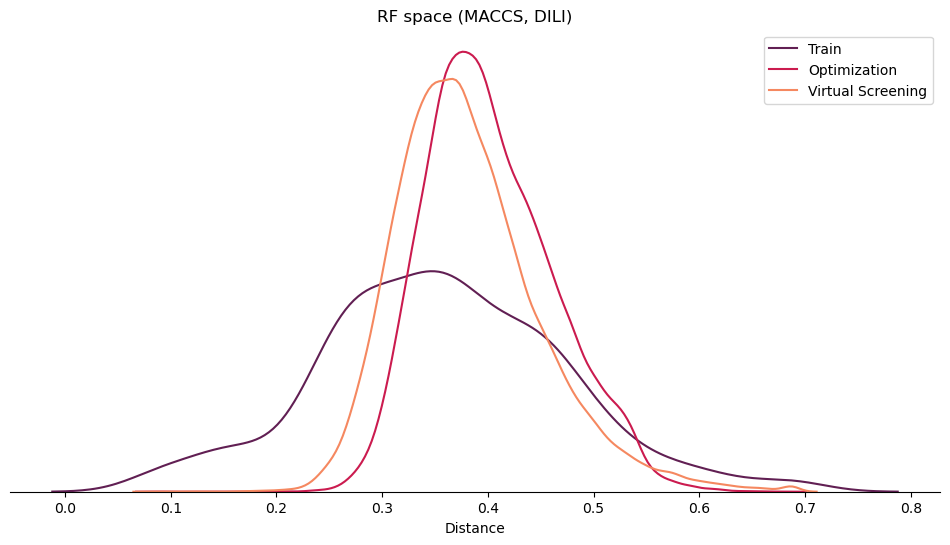

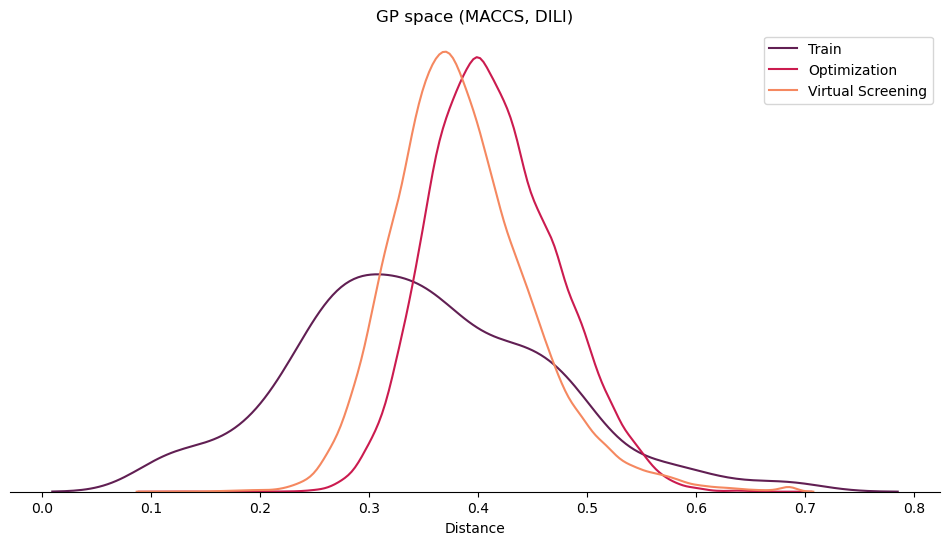

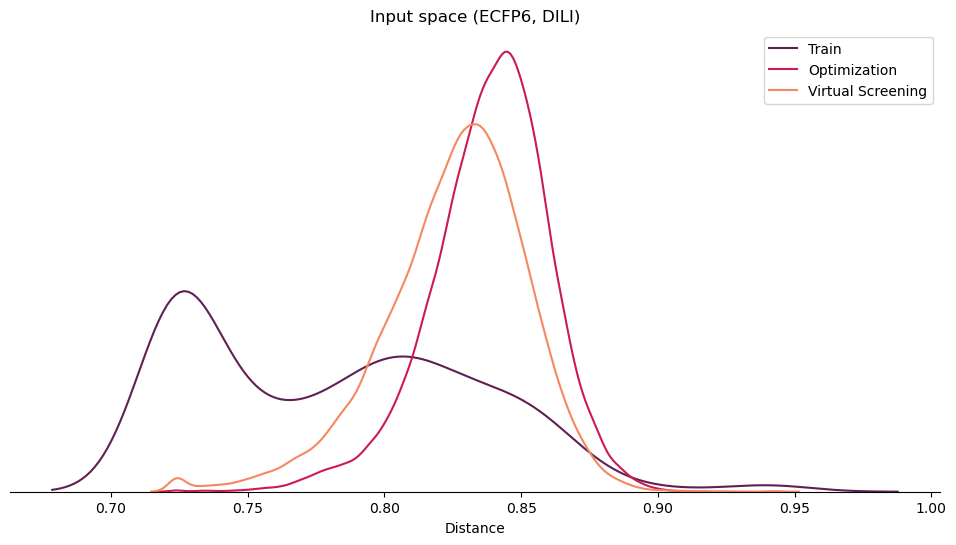

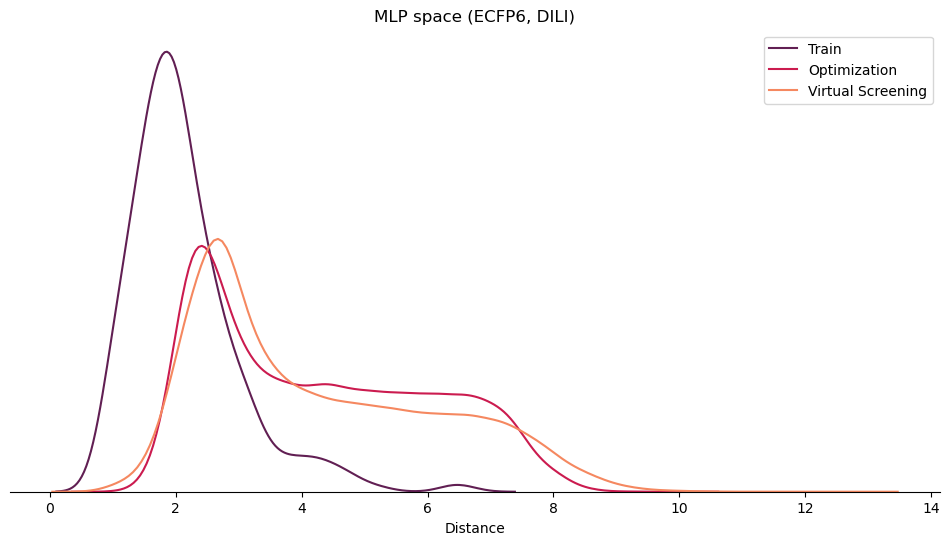

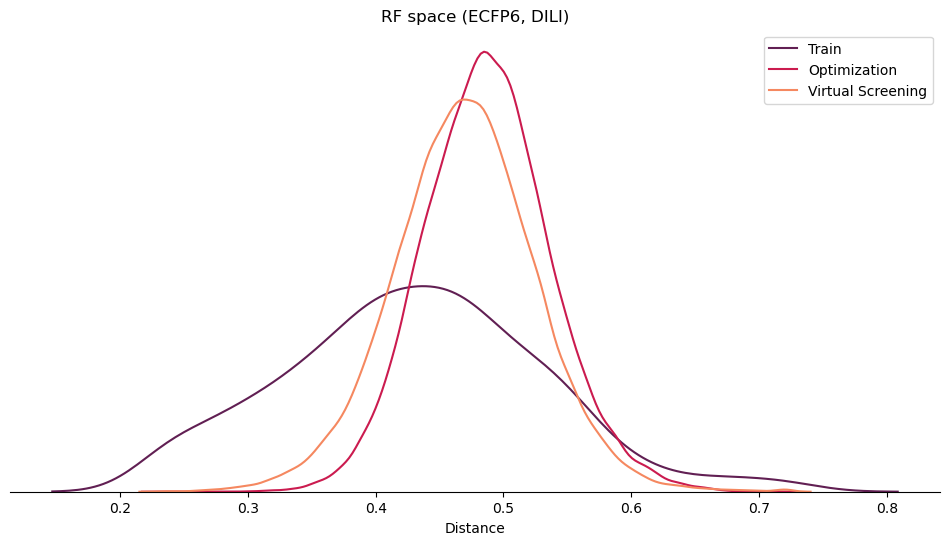

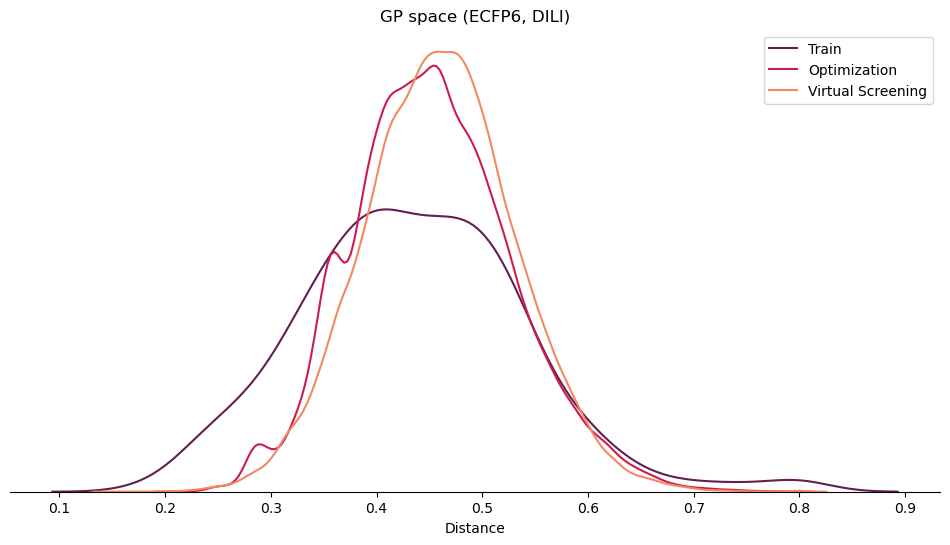

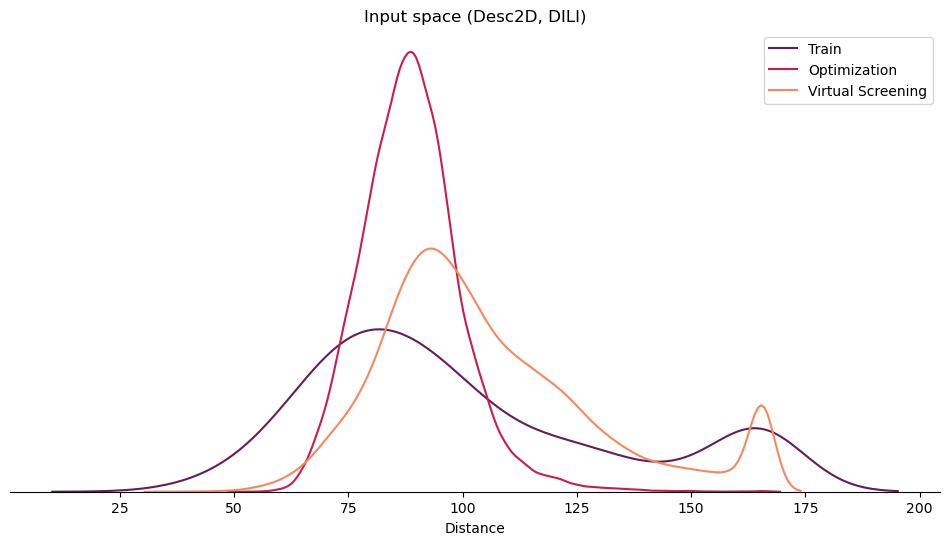

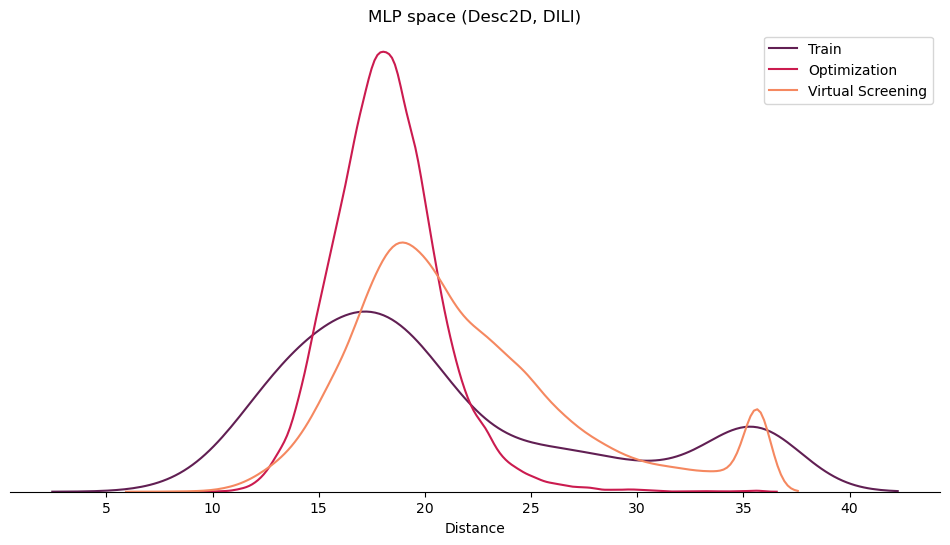

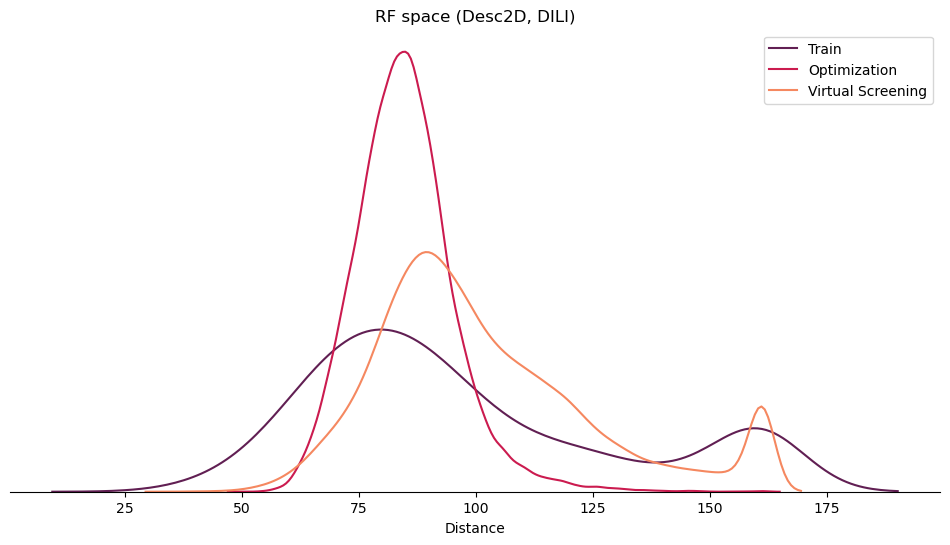

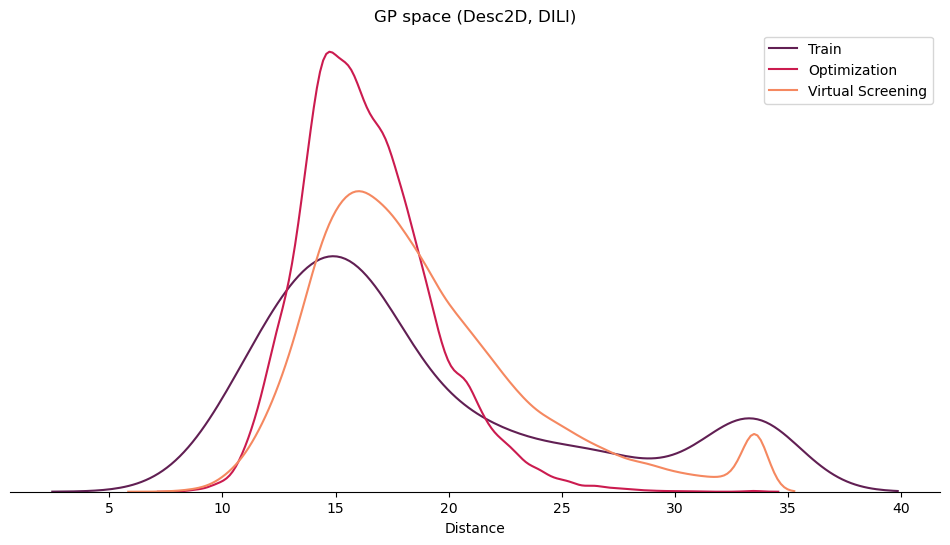

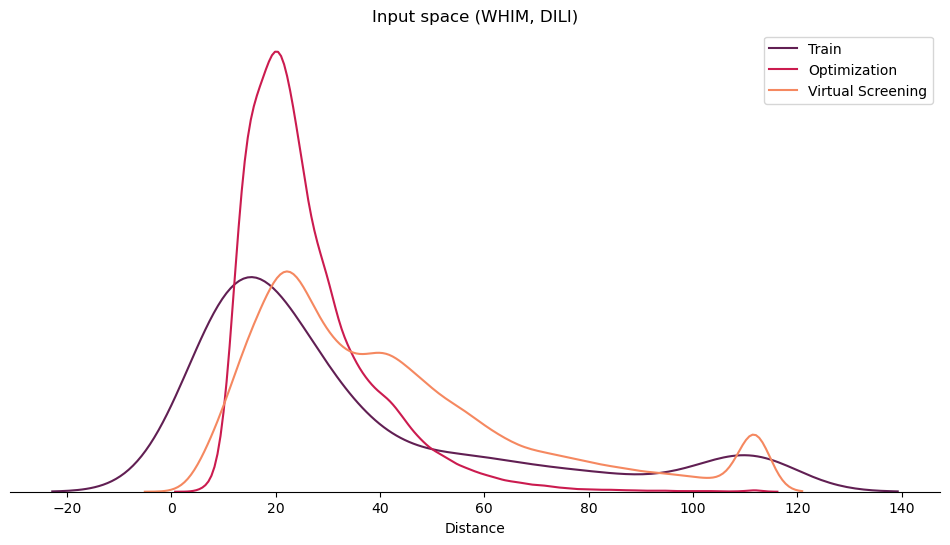

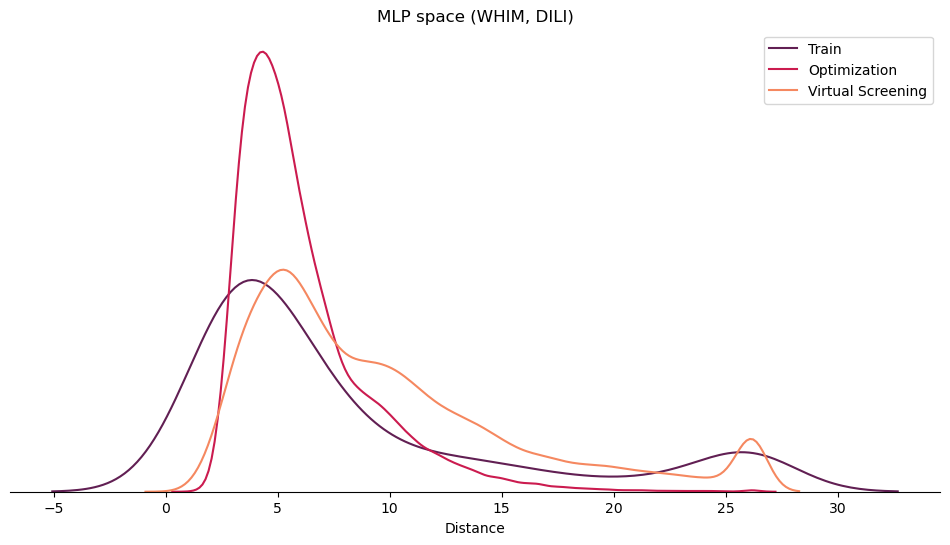

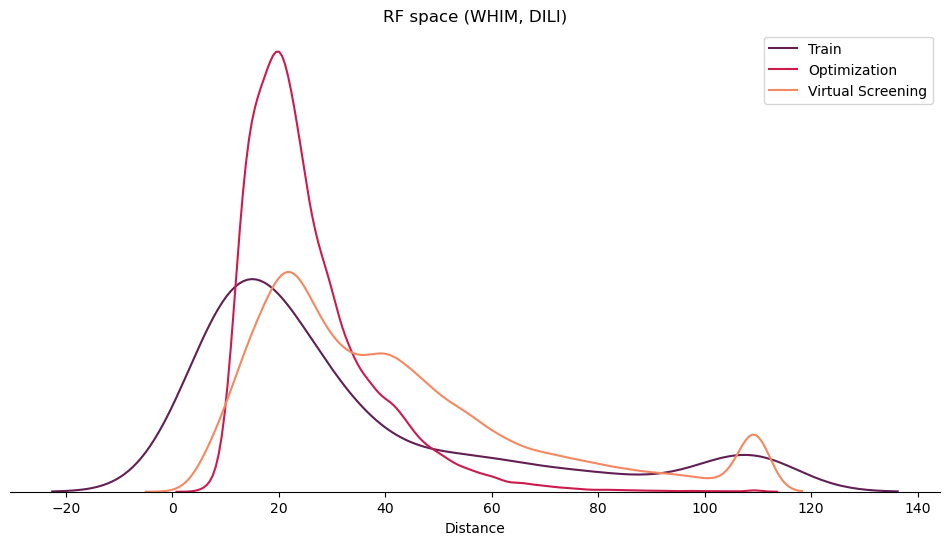

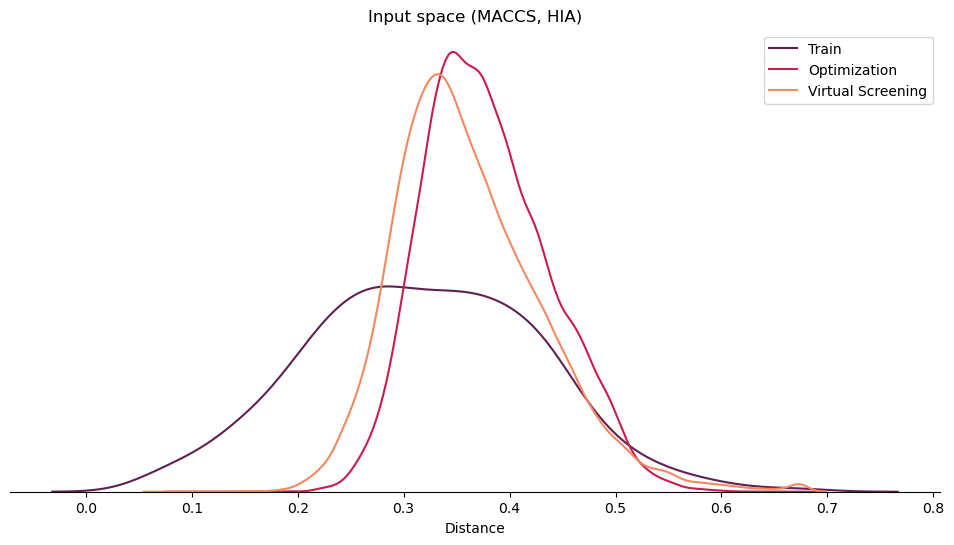

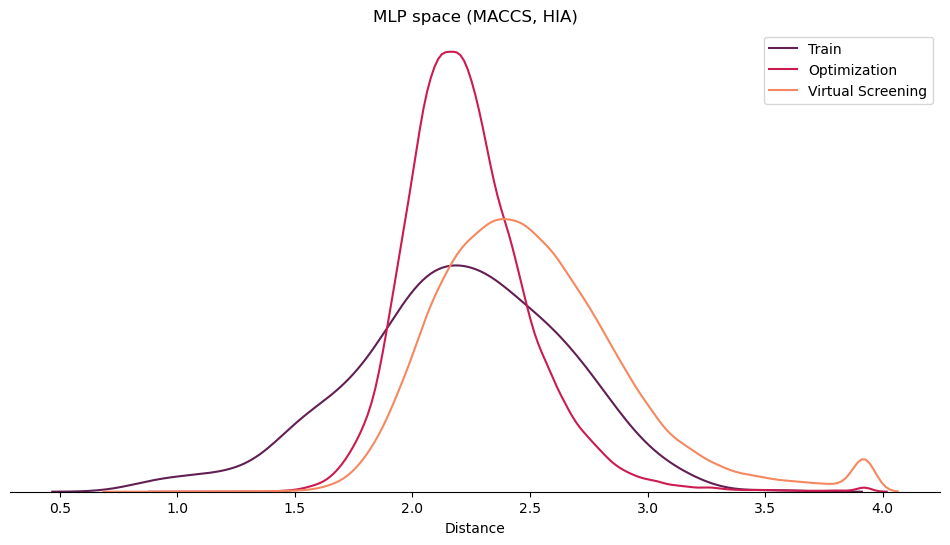

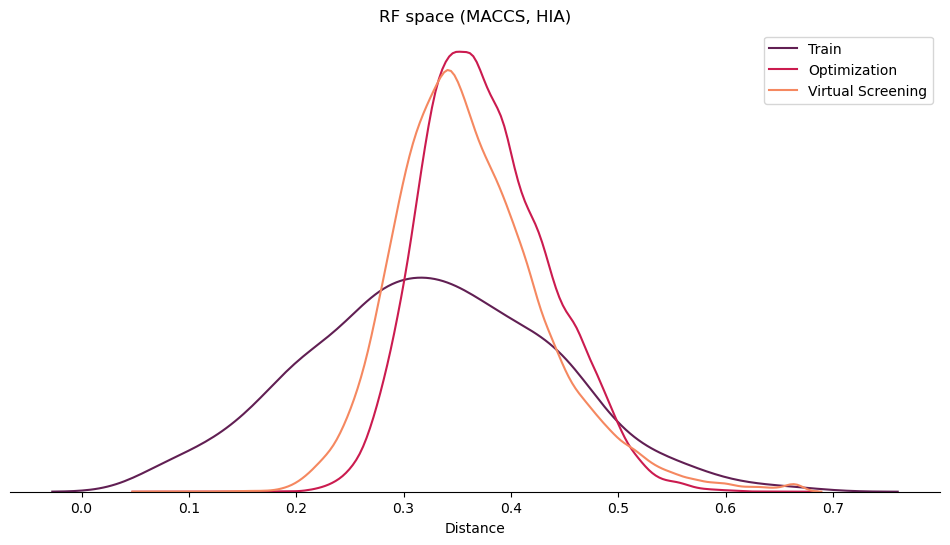

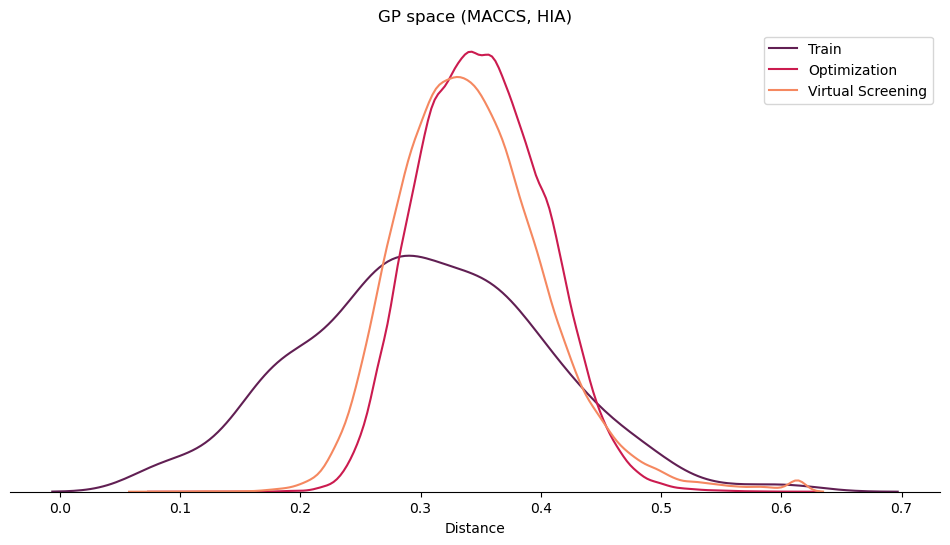

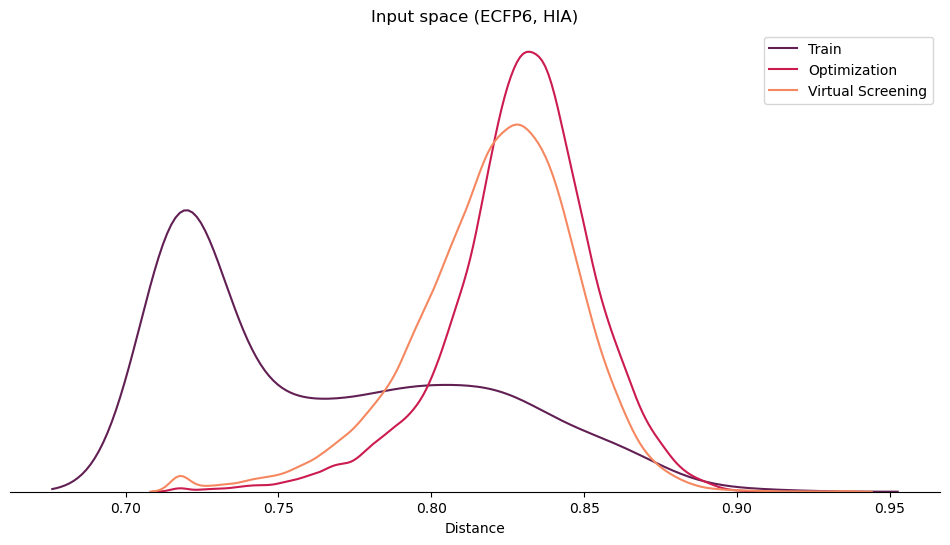

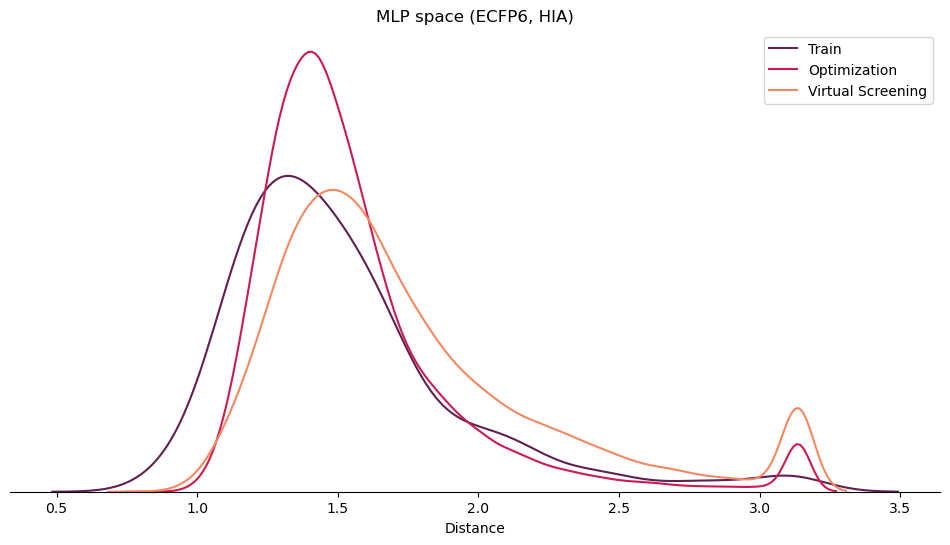

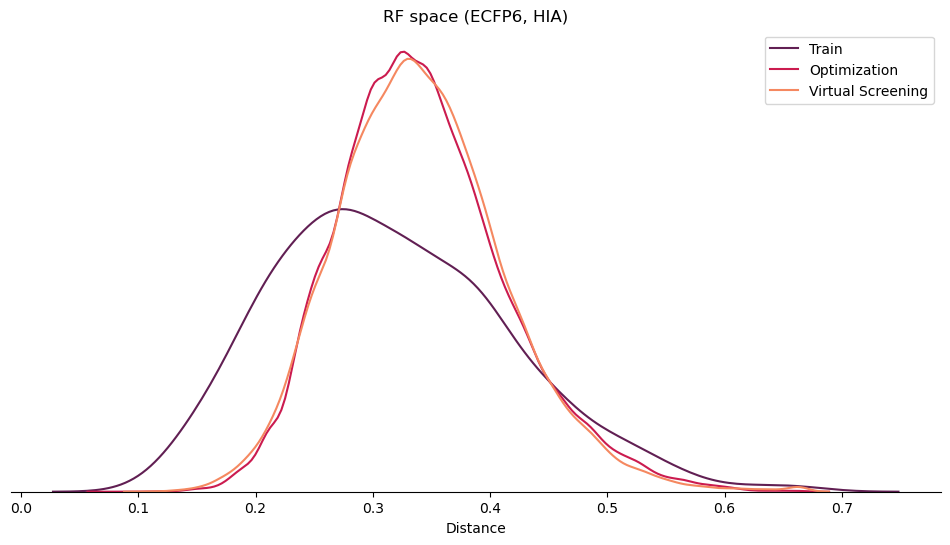

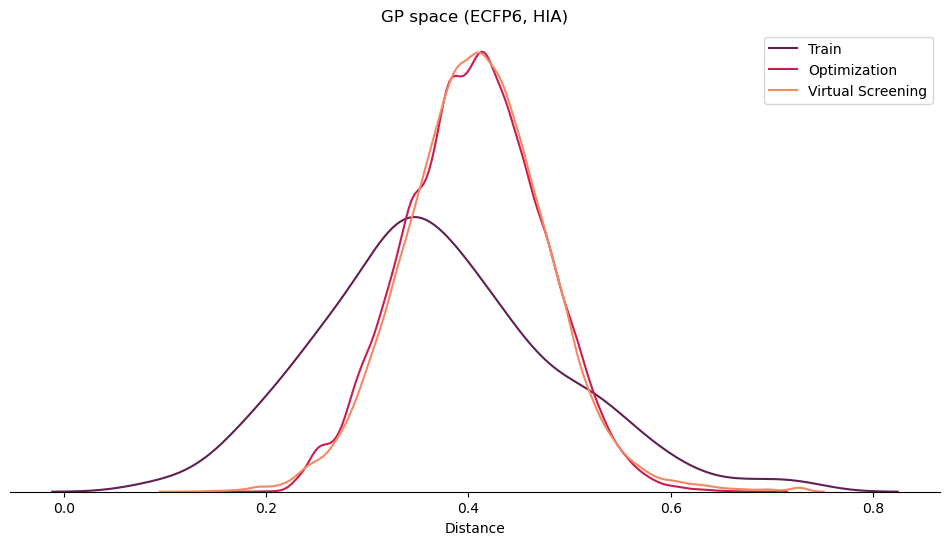

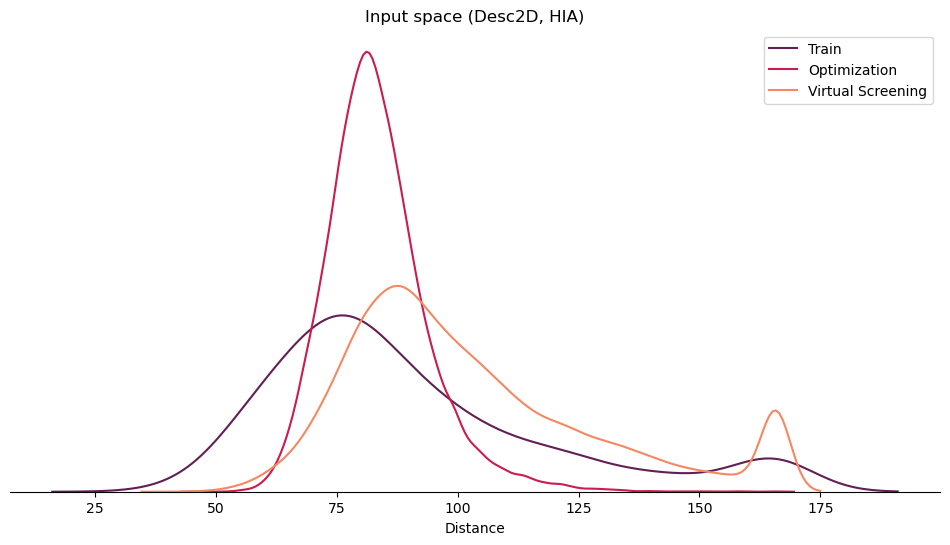

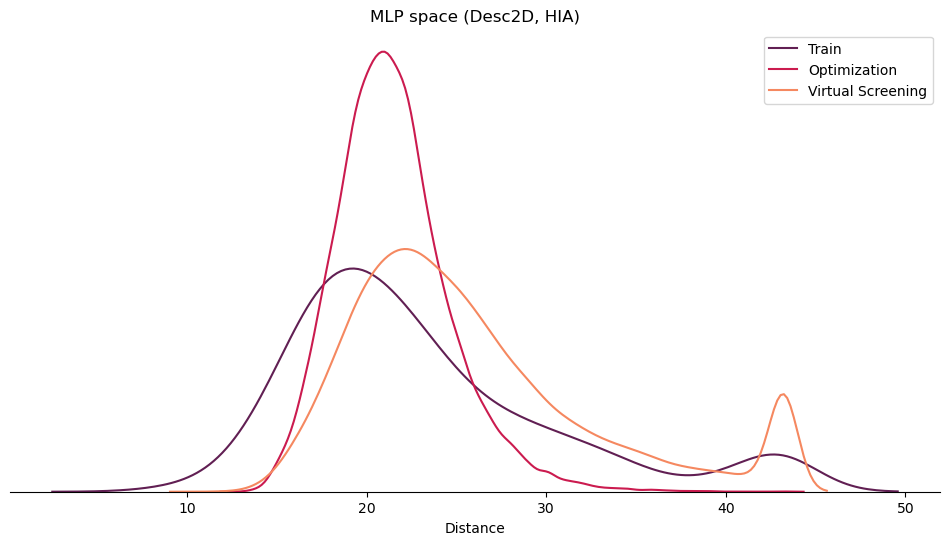

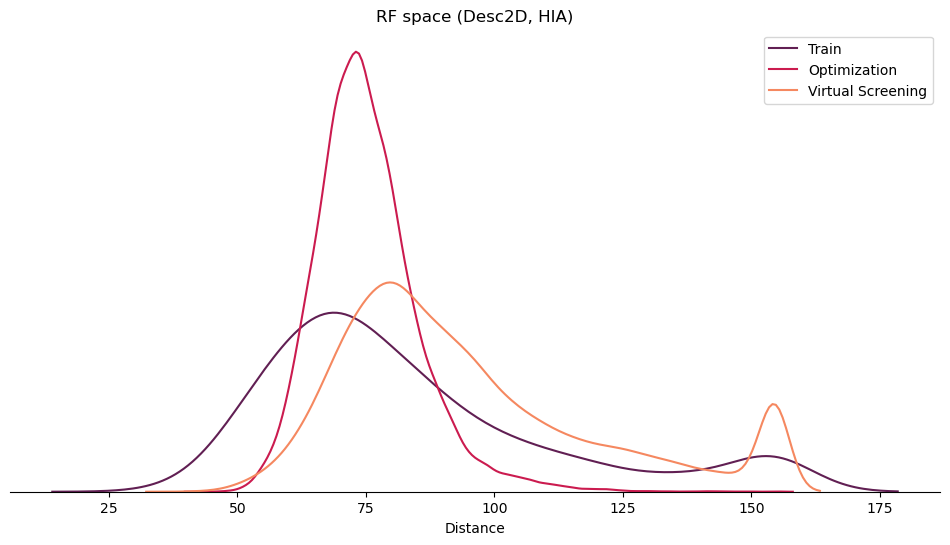

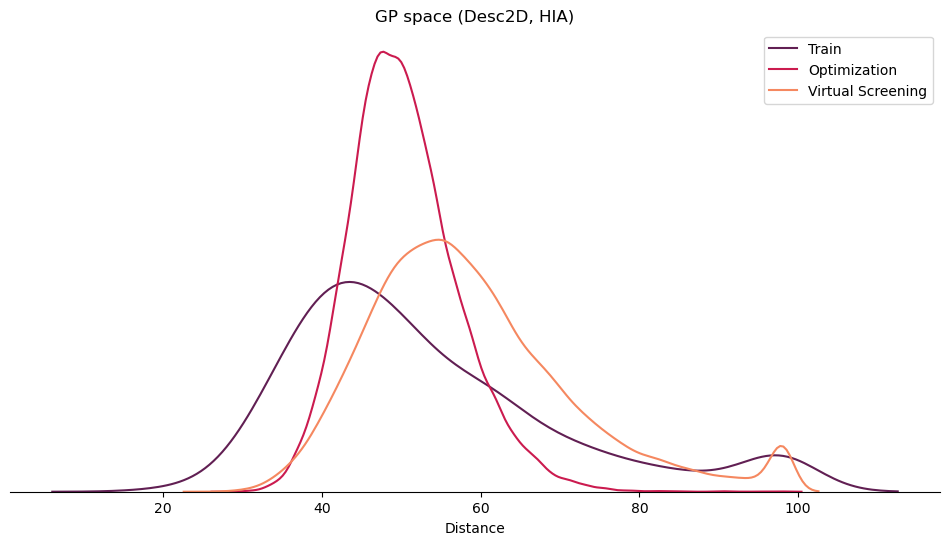

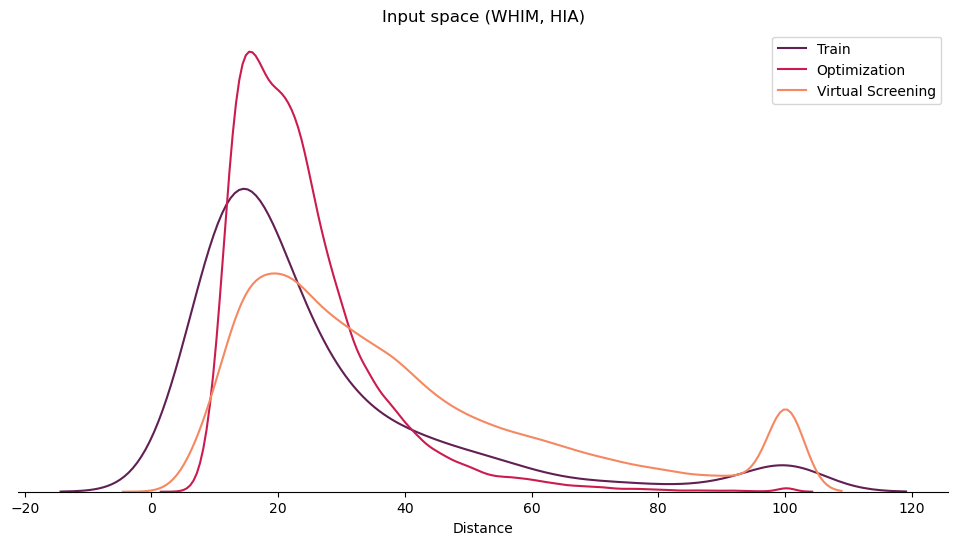

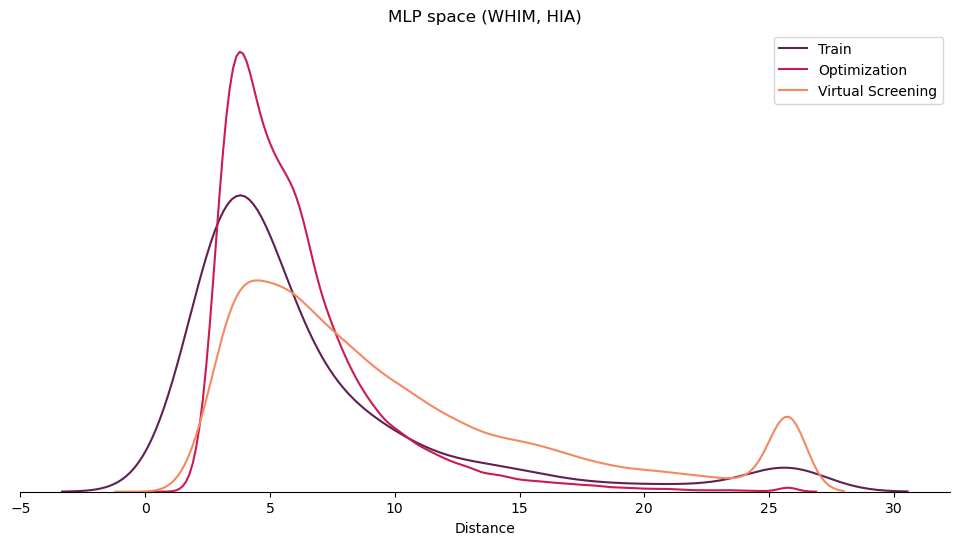

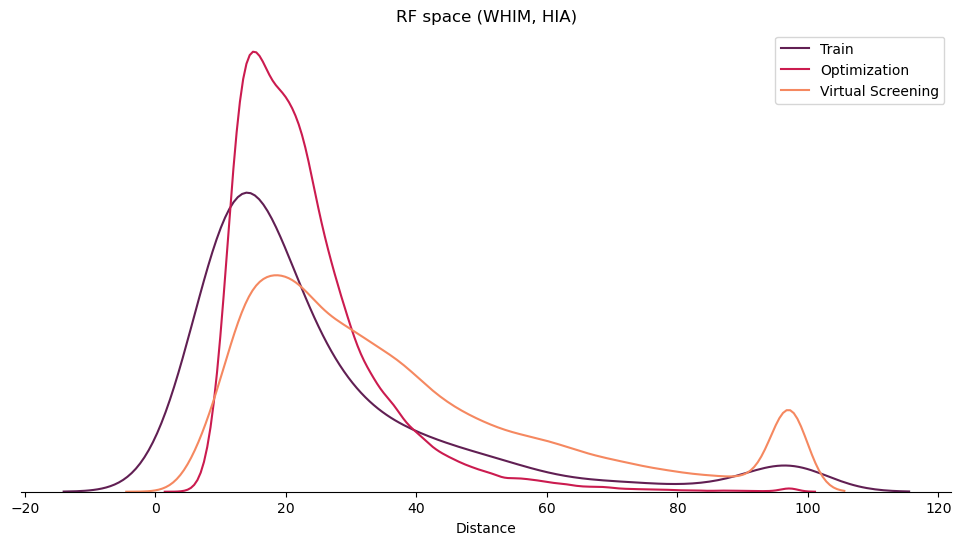

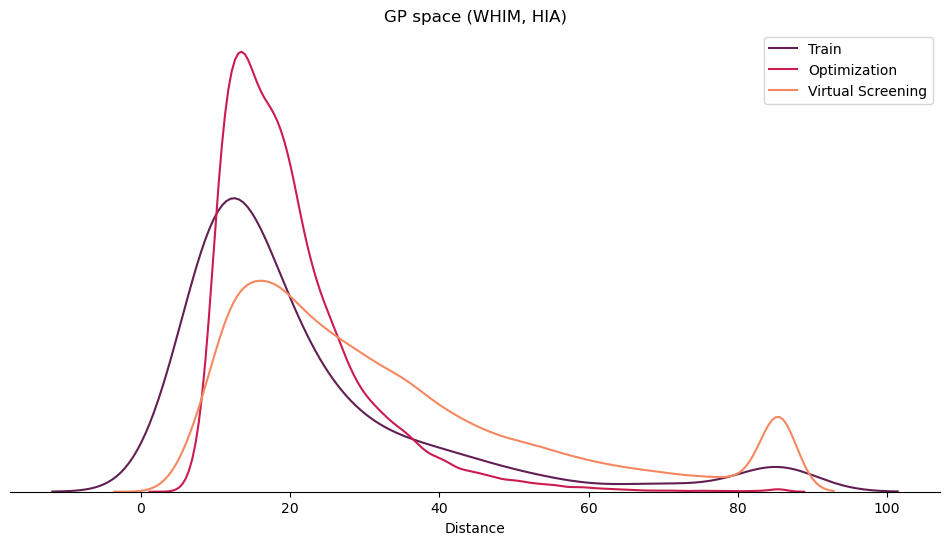

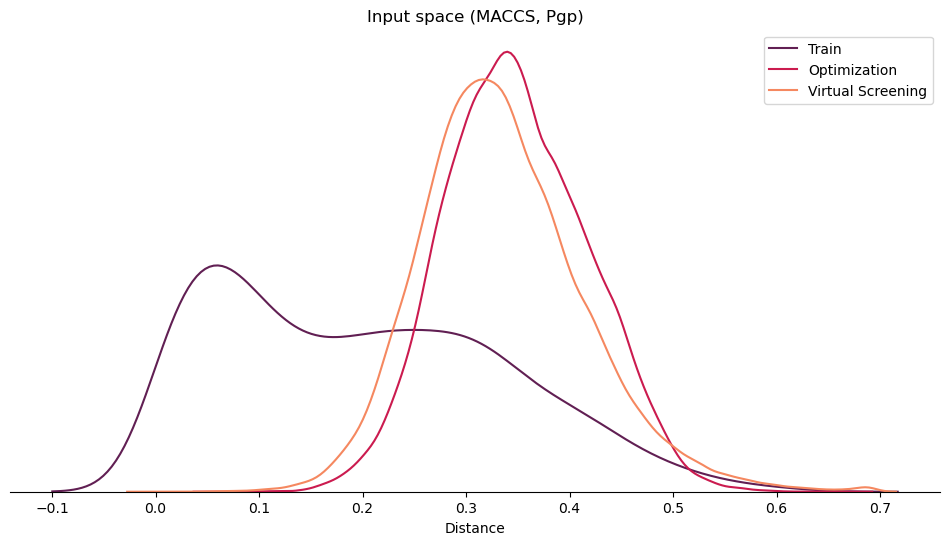

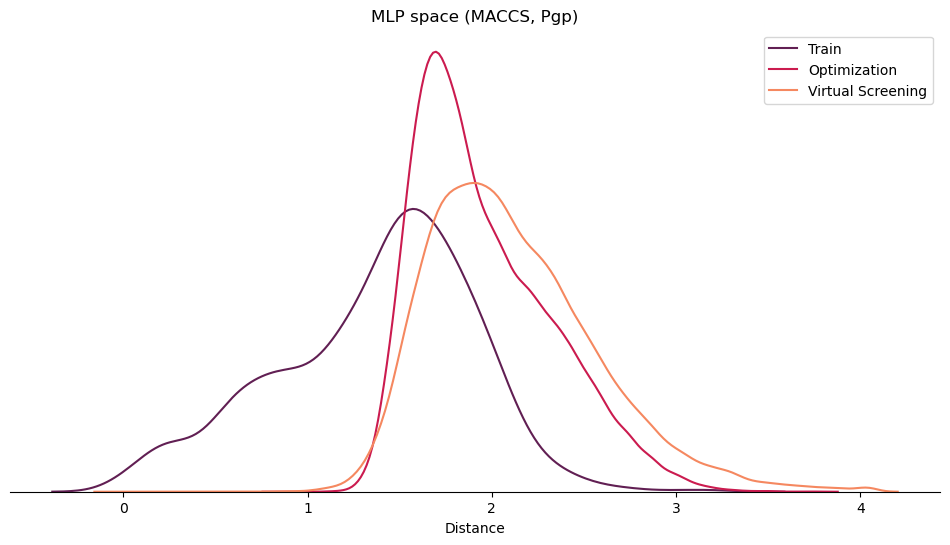

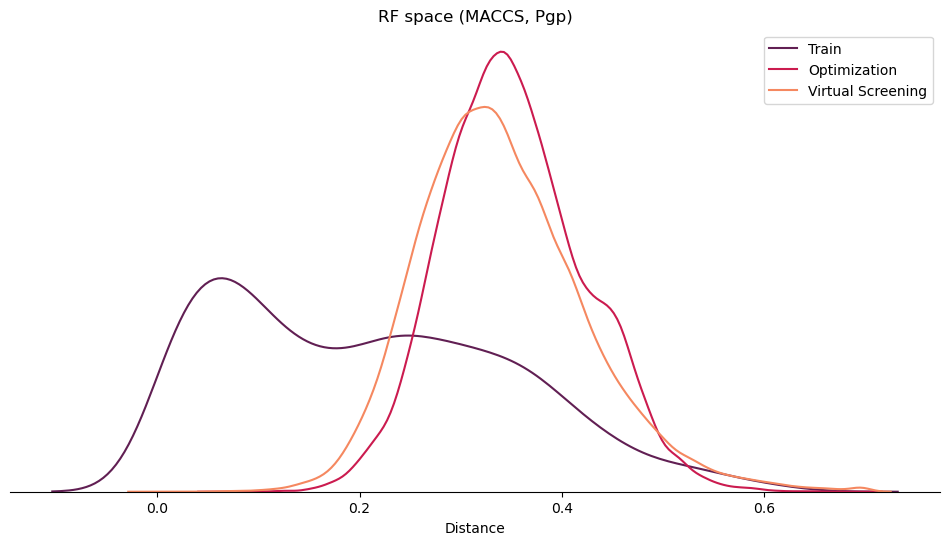

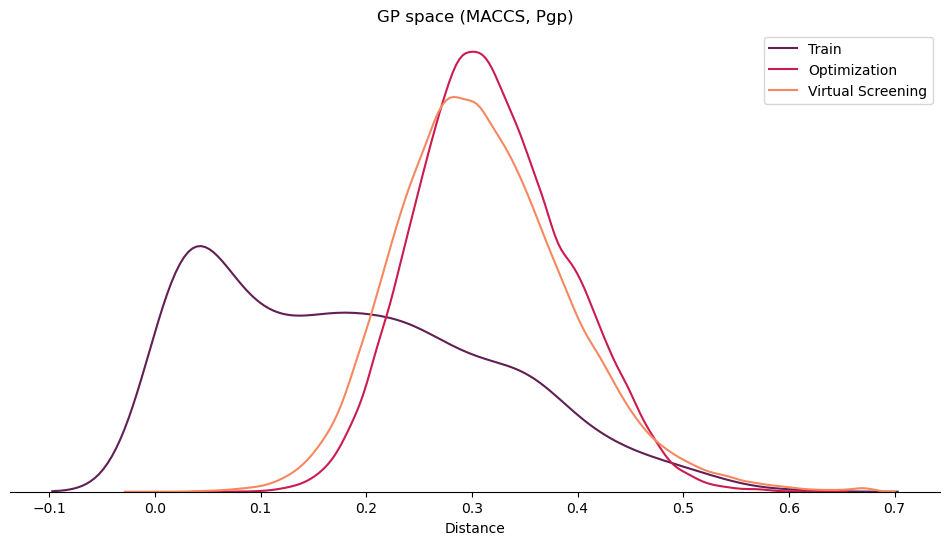

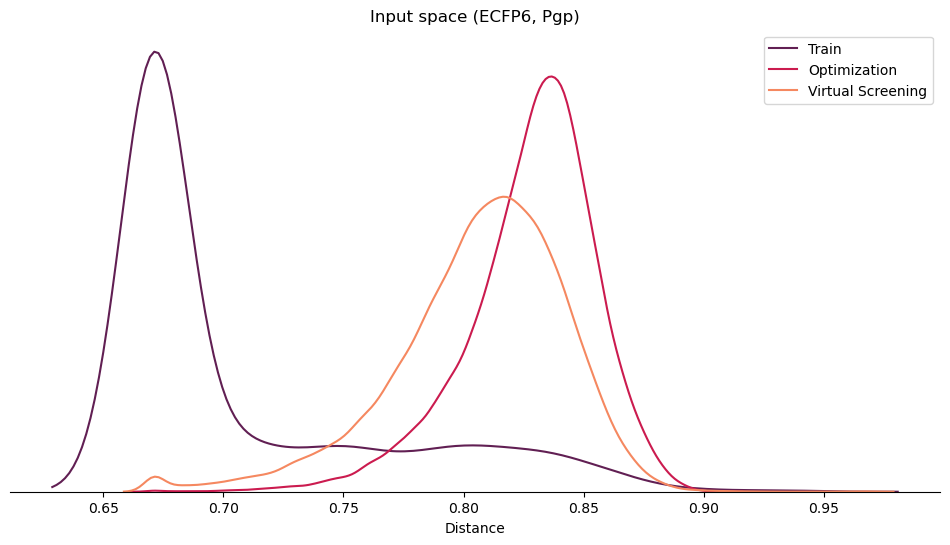

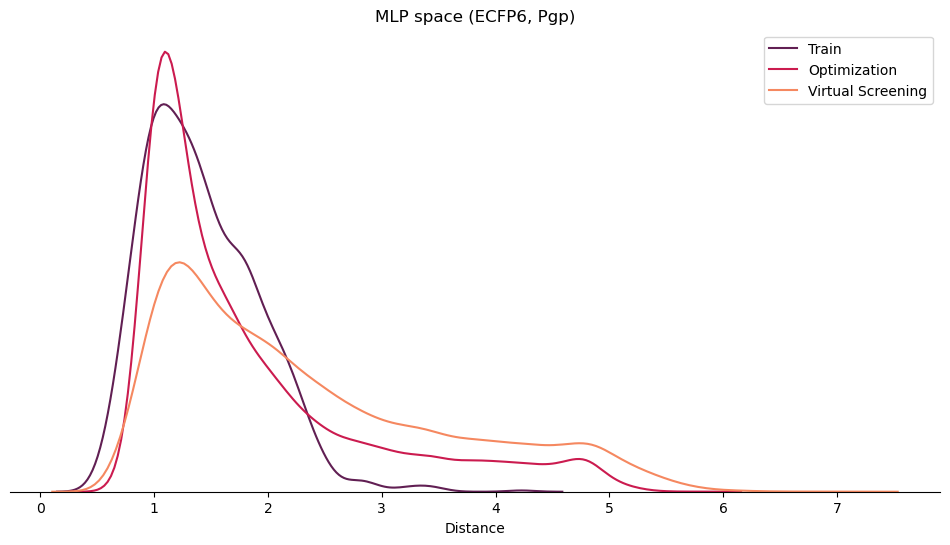

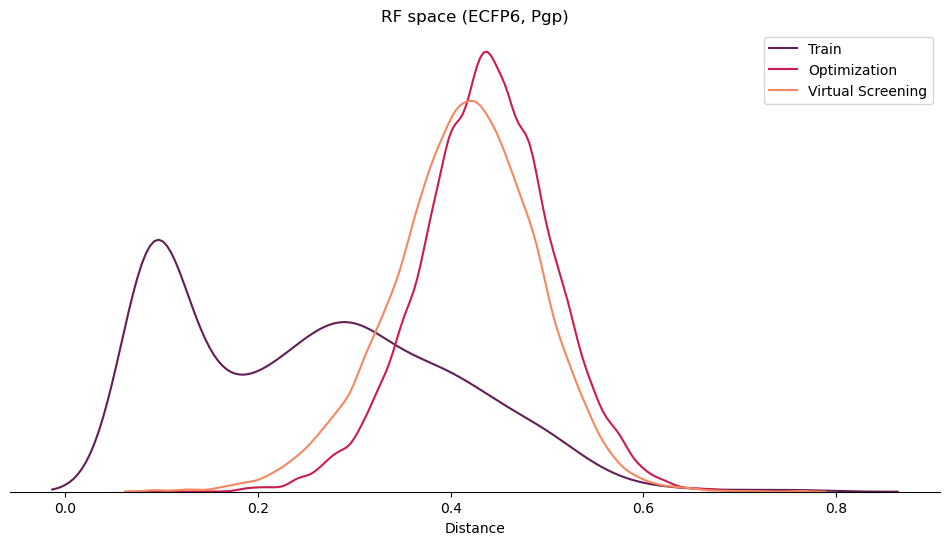

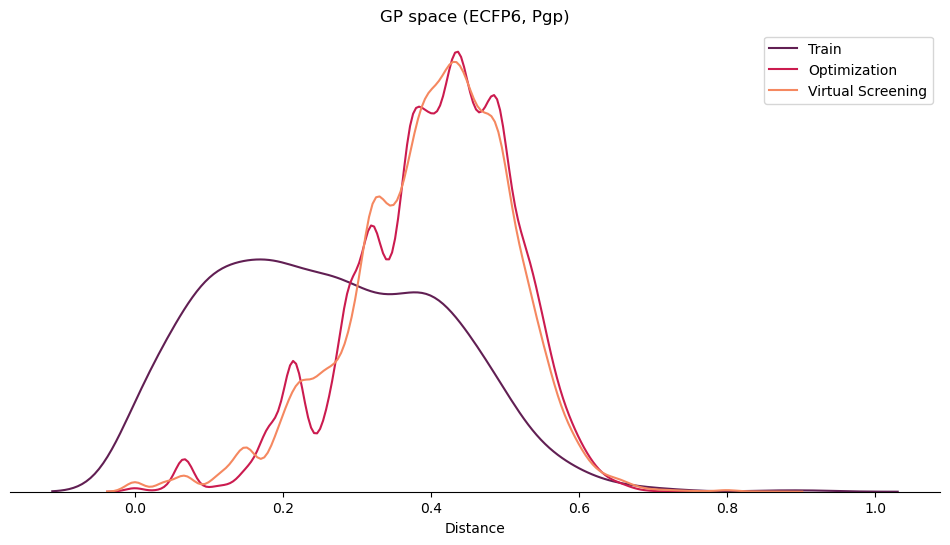

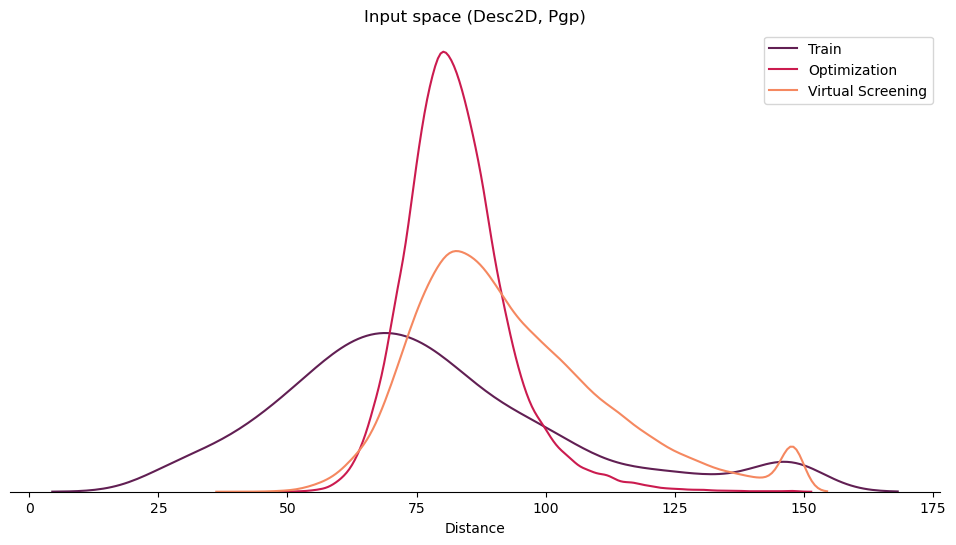

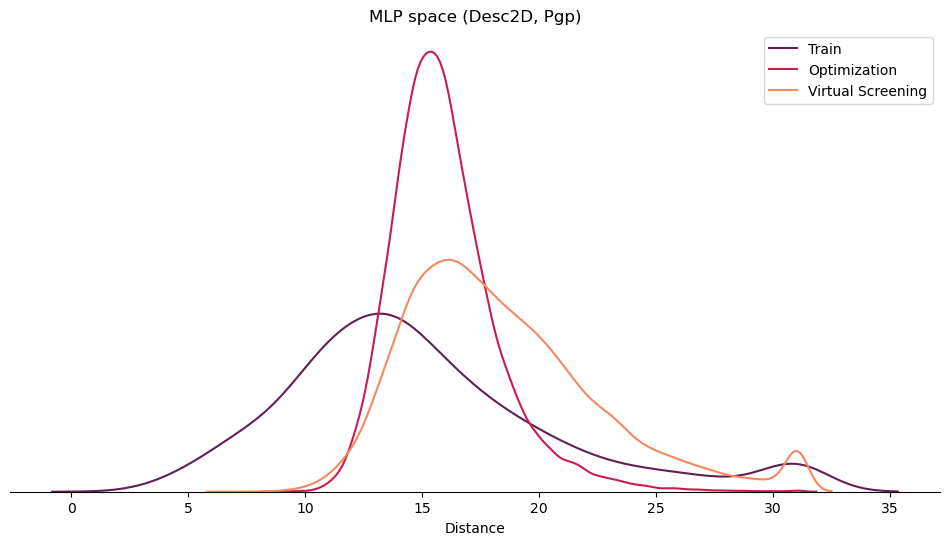

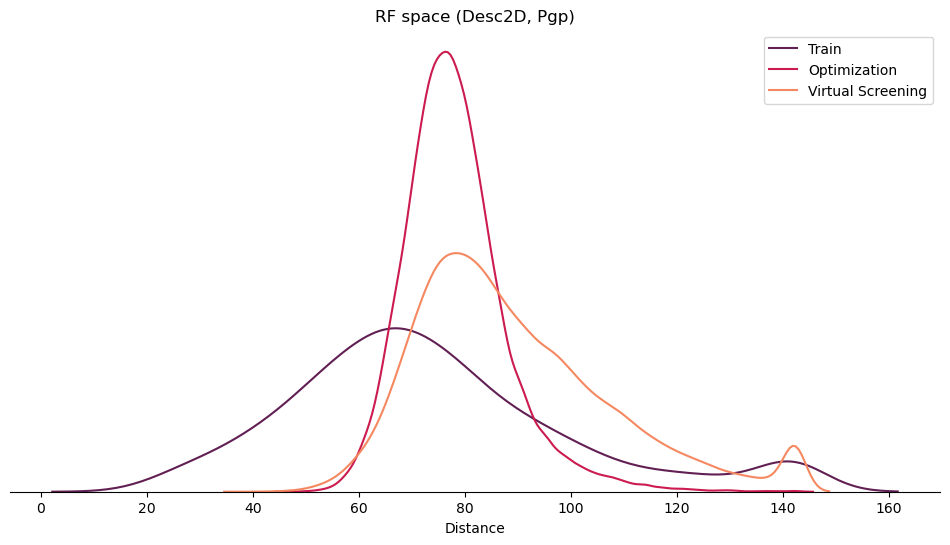

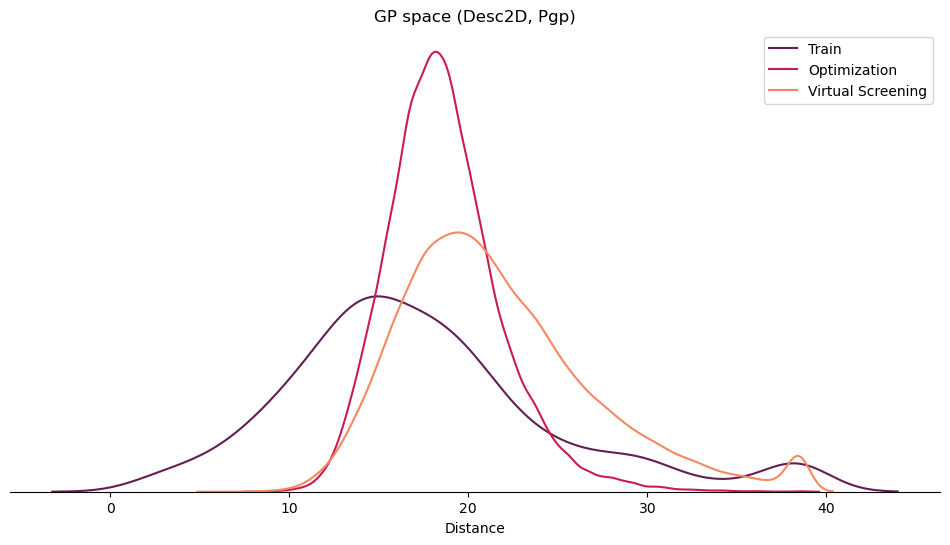

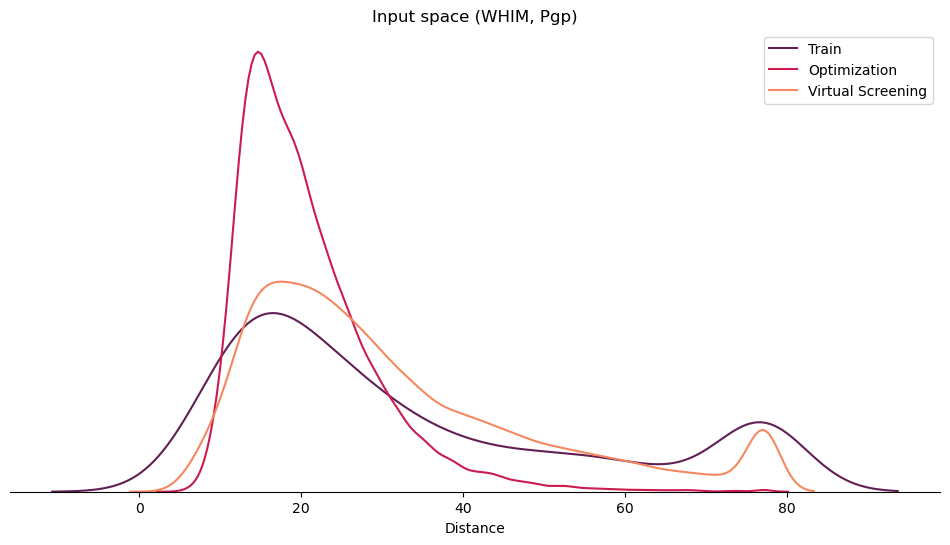

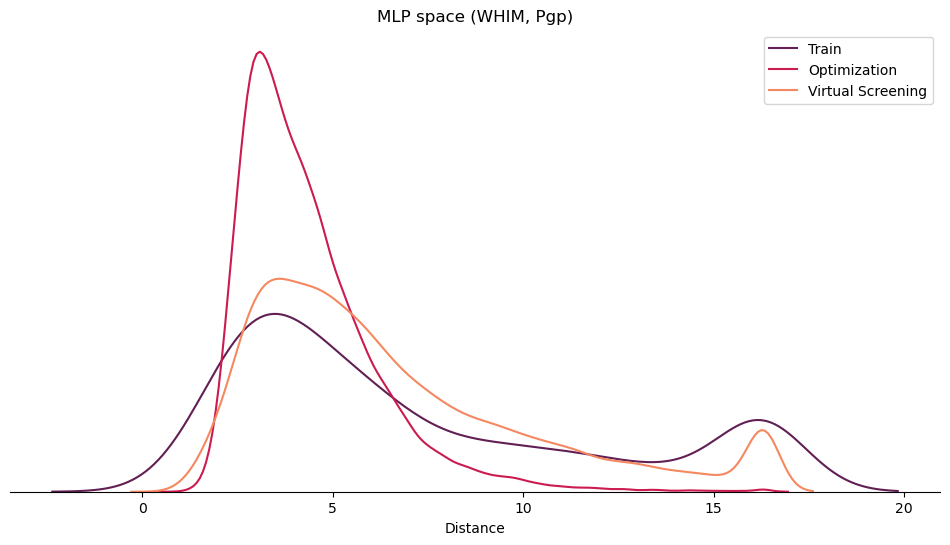

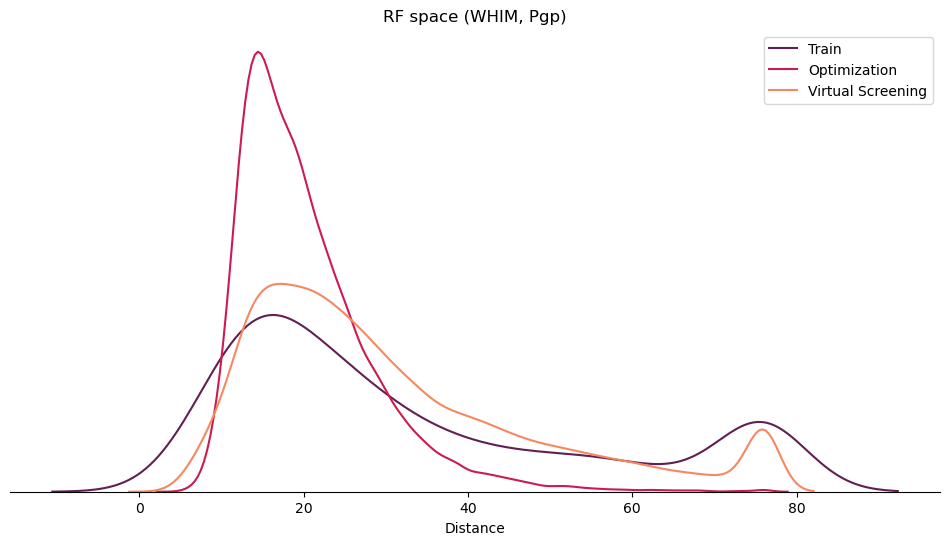

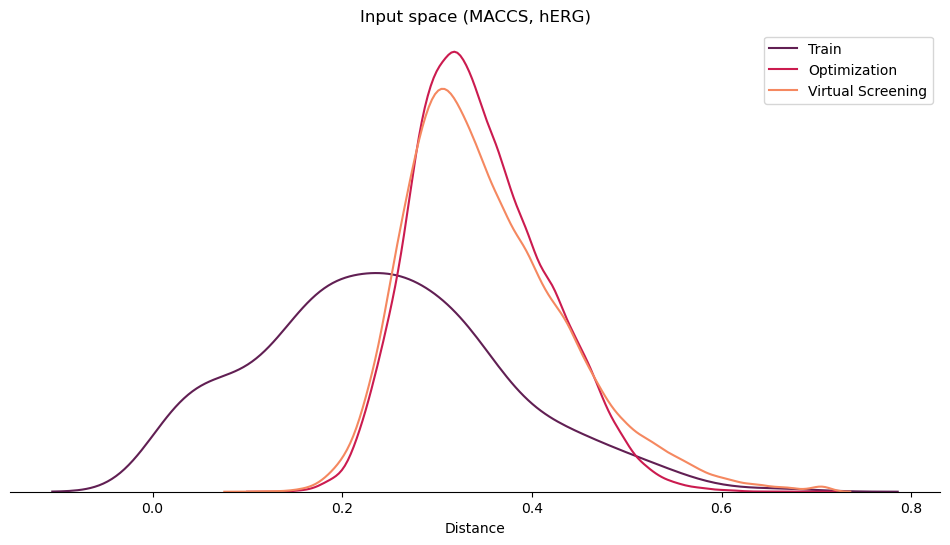

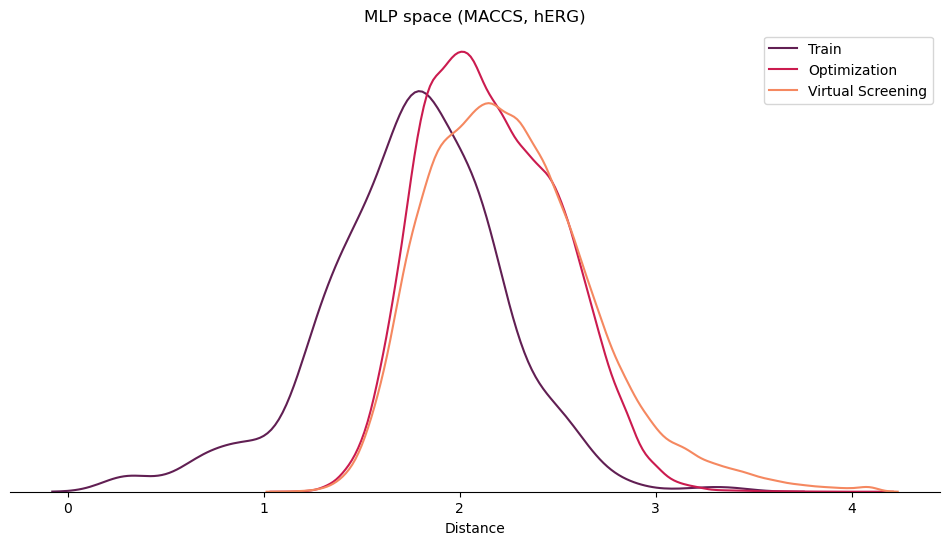

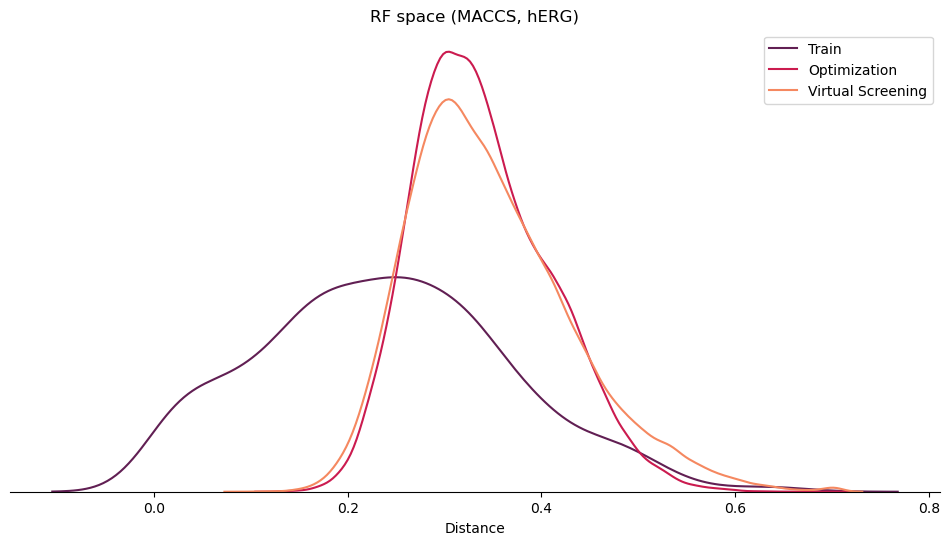

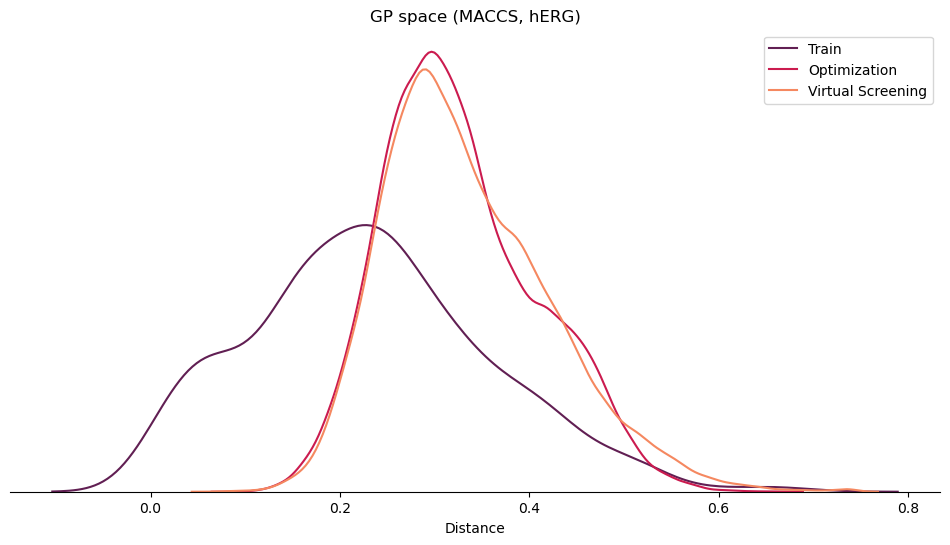

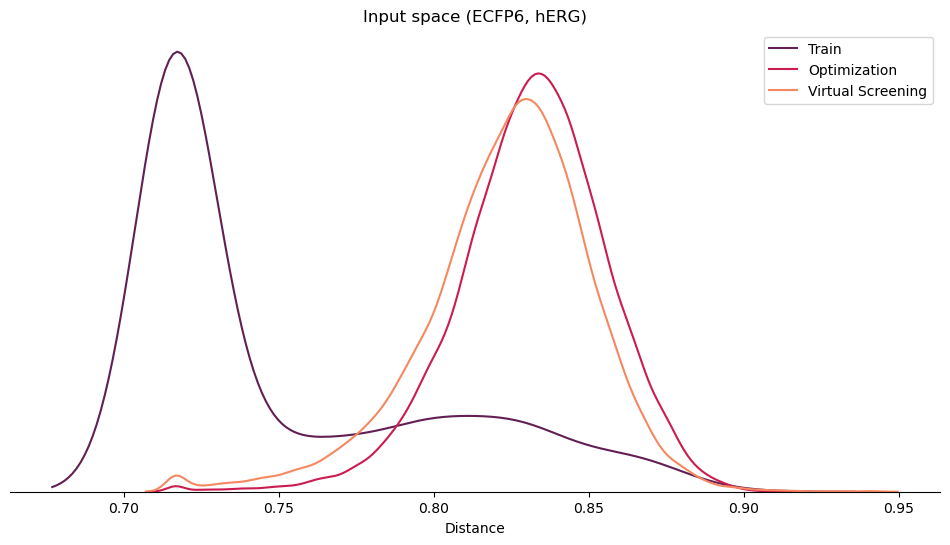

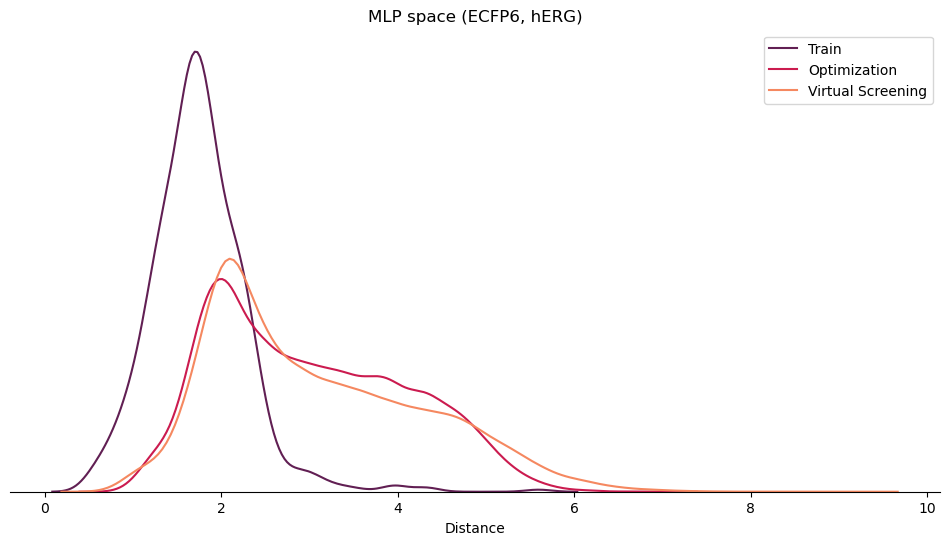

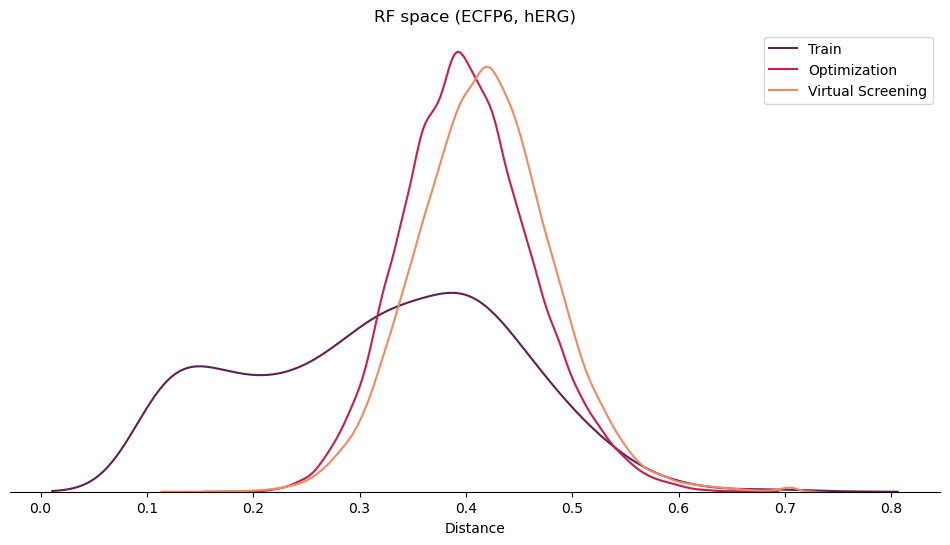

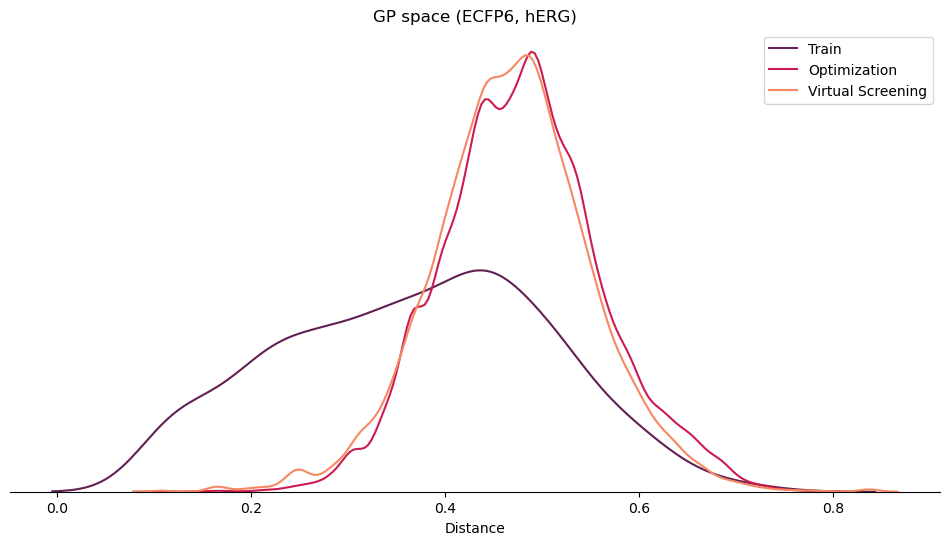

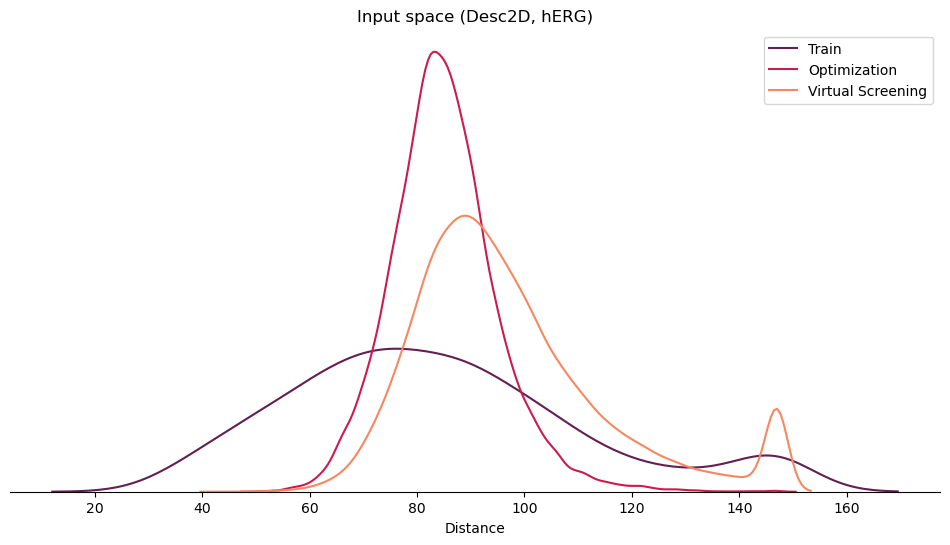

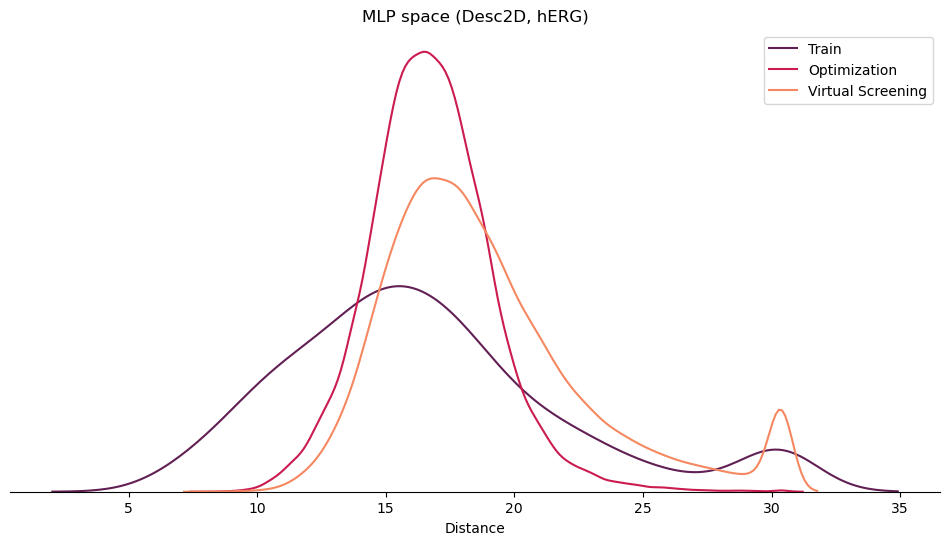

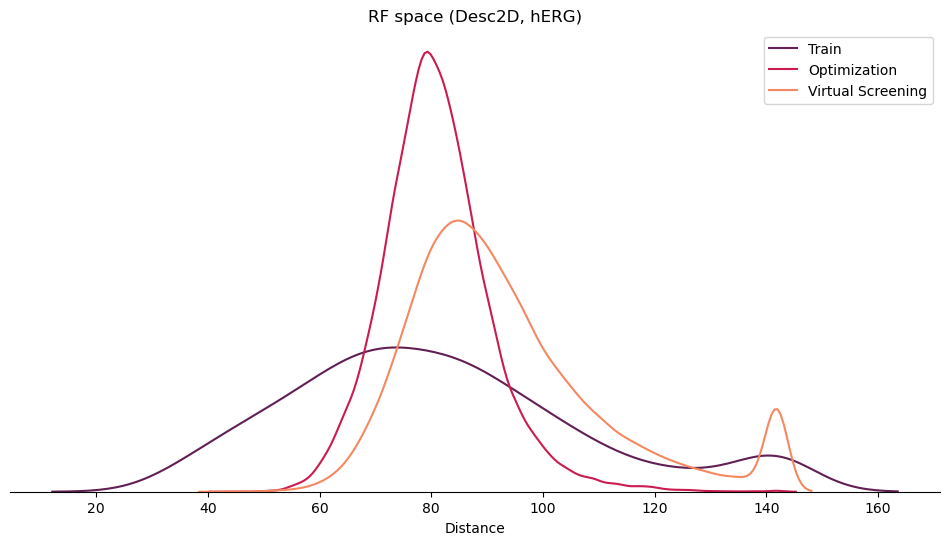

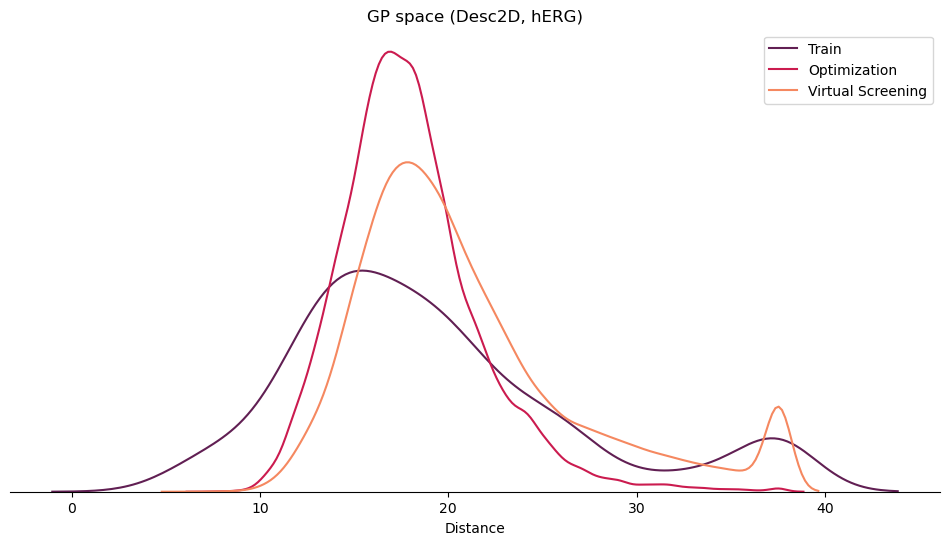

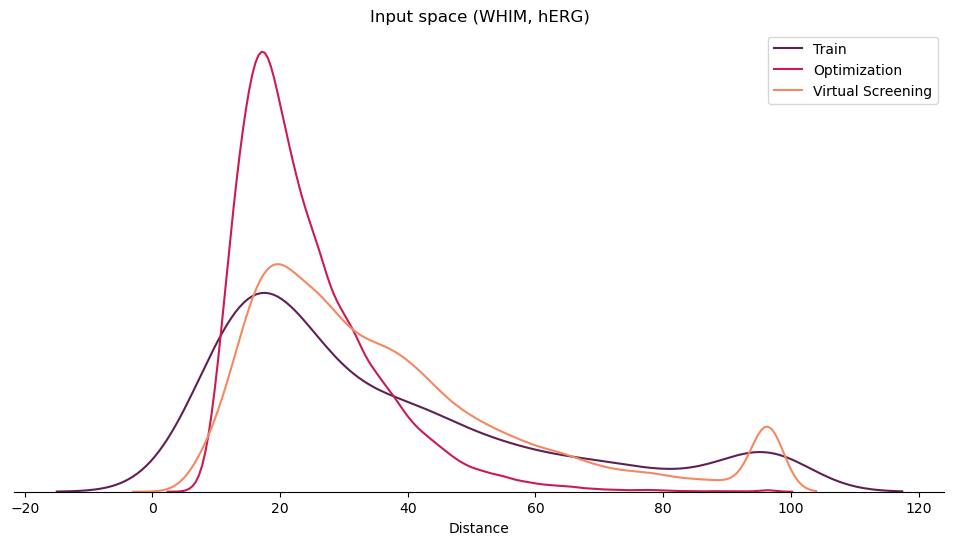

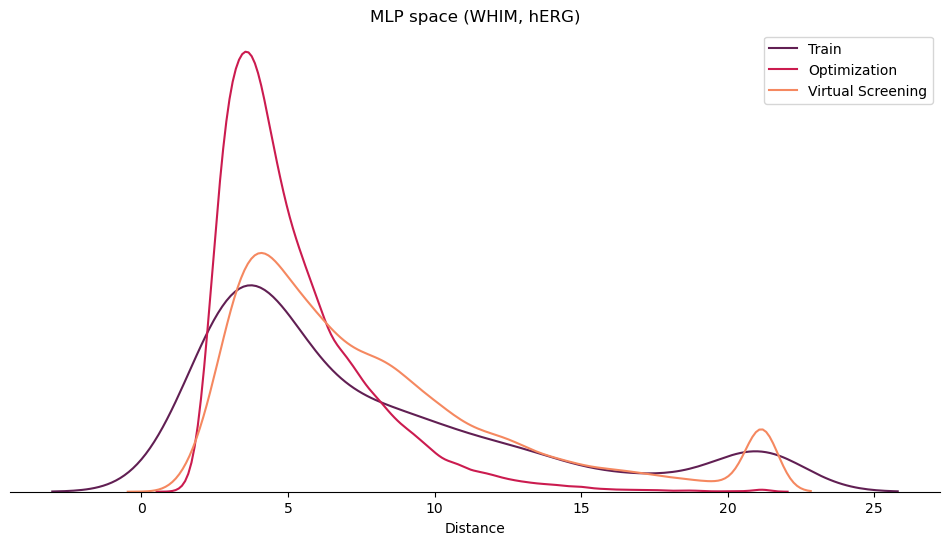

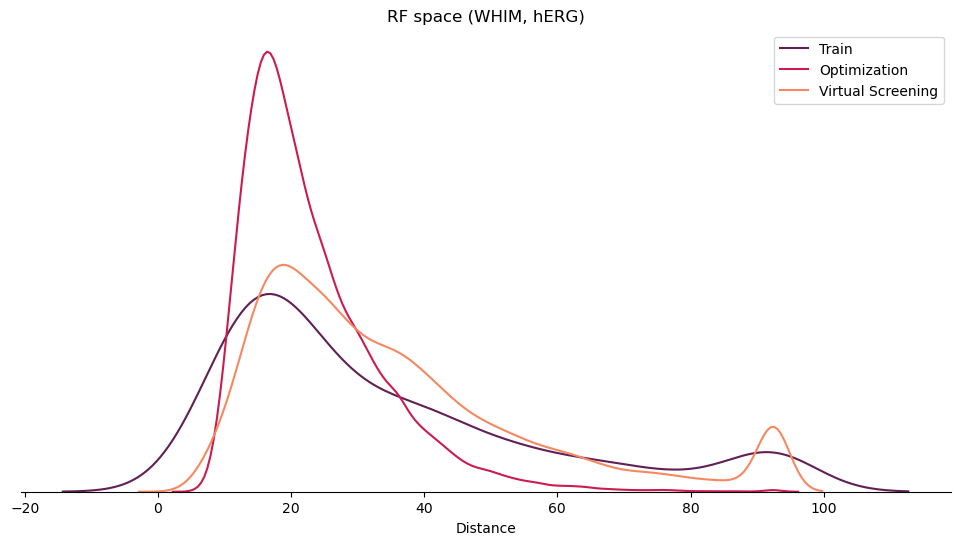

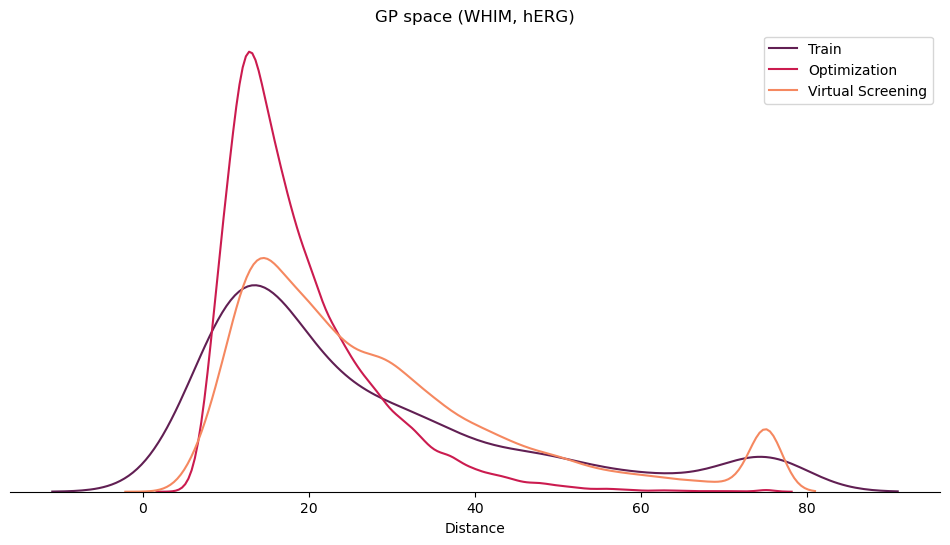

In [4]:
whitelist = MOOD_CLSF_DATASETS[2:]

for dataset, (smiles, y) in dataset_iterator(standardize_smiles, whitelist=whitelist, progress=True):

    for representation, (X, mask) in representation_iterator(smiles, n_jobs=-1, progress=True):
            
        y_repr = y[mask]
        
        virtual_screening = load_representation_for_downstream_application("virtual_screening", representation)
        optimization = load_representation_for_downstream_application("optimization", representation)
        
        # Train an MLP
        if dataset in MOOD_REGR_DATASETS:
            mlp_model = MLPRegressor(hidden_layer_sizes=(128, 128, 128,), random_state=0)
        else: 
            mlp_model = MLPClassifier(hidden_layer_sizes=(128, 128, 128,), random_state=0)
        mlp_model.fit(X, y_repr)

        # Train an RF
        if dataset in MOOD_REGR_DATASETS:
            rf_model = RandomForestRegressor(random_state=0)
        else: 
            rf_model = RandomForestClassifier(random_state=0)            
        rf_model.fit(X, y_repr)

        # Compute distances in different spaces
        input_distances = compute_knn_distance(X, [X, optimization, virtual_screening], n_jobs=-1)
        mlp_distances = get_model_space_distances(mlp_model, X, [X, optimization, virtual_screening])
        rf_distances = get_model_space_distances(rf_model, X, [X, optimization, virtual_screening])
    
        # Plot
        labels = ["Train", "Optimization", "Virtual Screening"]
        ax = plot_distance_distributions(input_distances, labels=labels)
        ax.set_title(f"Input space ({representation}, {dataset})")
        save_figure_with_fsspec(dm.fs.join(save_dir, f"{dataset}_{representation}_input_space.png"), exist_ok=OVERWRITE)

        ax = plot_distance_distributions(mlp_distances, labels=labels)
        ax.set_title(f"MLP space ({representation}, {dataset})")
        save_figure_with_fsspec(dm.fs.join(save_dir, f"{dataset}_{representation}_mlp_space.png"), exist_ok=OVERWRITE)
        
        ax = plot_distance_distributions(rf_distances, labels=labels)
        ax.set_title(f"RF space ({representation}, {dataset})")
        save_figure_with_fsspec(dm.fs.join(save_dir, f"{dataset}_{representation}_rf_space.png"), exist_ok=OVERWRITE)
        
        # Treat GPs separately as we might want to increase alpha
        alpha = 1e-10
        success = False
        for i in range(10):
            try: 
                
                if dataset in MOOD_CLSF_DATASETS:
                    kernel = Sum(PairwiseKernel(metric="linear"), WhiteKernel(noise_level=alpha))
                    gp_model = GaussianProcessClassifier(kernel, random_state=0)
                    gp_model.fit(X, y_repr)
                else:
                    kernel = PairwiseKernel(metric="linear")
                    gp_model = GaussianProcessRegressor(kernel, alpha=alpha, random_state=0)
                    gp_model.fit(X, y_repr)
                
                success = True 
                break
                
            except np.linalg.LinAlgError:
                alpha = alpha * 10
            except ValueError: 
                break
            
        if not success:
            continue
            
        gp_distances = get_model_space_distances(gp_model, X, [X, optimization, virtual_screening])

        ax = plot_distance_distributions(gp_distances, labels=labels)
        ax.set_title(f"GP space ({representation}, {dataset})")
        save_figure_with_fsspec(dm.fs.join(save_dir, f"{dataset}_{representation}_gp_space.png"), exist_ok=OVERWRITE)


The End.